In [2]:
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
#from sklearn.cluster import KMeans
#from sklearn import metrics


In [3]:
import logging
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

#### Configs

In [ ]:
# pd.set_option("display.max_columns", None)
# pd.set_option("display.max_rows", None)

### A. Load data

In [5]:
raw = pd.read_csv("../data/base_customers_all_years_z7.csv")
raw['date'] = pd.to_datetime(raw['date'])
raw['year'] = raw['date'].dt.year
raw['month'] = raw['date'].dt.month

### B. Clean up

In [6]:
# remove negative demand
n_negative = len(raw[raw.demand <=0].index)
raw = raw[raw.demand > 0].reset_index(drop=True)
logger.info(f"Quantity of rows with negative demand: {n_negative}")

# compute percentiles
percentil_1 = raw['demand'].quantile(0.01)
percentil_99_9 = raw['demand'].quantile(0.999)

# Filter records
n_rows = len(raw.index)
n_removed = len(raw[(raw['demand'] < percentil_1) | (raw['demand'] > percentil_99_9)])
raw = raw[(raw['demand'] >= percentil_1) & (raw['demand'] < percentil_99_9)].reset_index(drop=True)

logger.info(f"Quantity of rows removed: {n_removed} of total {n_rows}")

INFO:__main__:Quantity of rows with negative demand: 66430
INFO:__main__:Quantity of rows removed: 4484 of total 2702405


In [7]:
raw_grouped = raw.groupby(["year","month","cod_customer","lat","lon"]).agg(demand = ("demand","sum"),
                                                                            n_dates = ("date","nunique")).reset_index()
raw_grouped["demand"] = raw_grouped.apply(lambda x: x['demand']/25, axis=1)

### C. Transform

In [8]:
# Quantity of customers unique by year
raw_grouped.groupby(['year']).agg(n_customers = ("cod_customer","nunique"))

,n_customers
year,
2020,8472
2021,11061
2022,10098


In [9]:
raw_grouped_by_customer = raw_grouped.groupby(['year','cod_customer']).agg(demand = ("demand","sum"),
                                                                            n_dates = ("n_dates","sum")).reset_index()

In [10]:
_y1 = set(raw_grouped_by_customer[raw_grouped_by_customer.year==2020]['cod_customer'].unique())
_y2 = set(raw_grouped_by_customer[raw_grouped_by_customer.year==2021]['cod_customer'].unique())
_y3 = set(raw_grouped_by_customer[(raw_grouped_by_customer.year==2022) & (raw_grouped_by_customer.n_dates >= 12)]['cod_customer'].unique())

intersection_y3_y2 = _y3.intersection(_y2)
intersection_y3_y1 = _y3.intersection(_y1)

logger.info(f"Quantity of customer from 2022 who have demand-frequency greater than 12 times {len(_y3)}")
logger.info(f"Quantity of customer from 2022 present in 2021: {len(intersection_y3_y2)} - {(len(intersection_y3_y2) *100/ len(_y3)):.1f}%")
logger.info(f"Quantity of customer from 2022 present in 2020: {len(intersection_y3_y1)} - {(len(intersection_y3_y1) *100/ len(_y3)):.1f}%")

INFO:__main__:Quantity of customer from 2022 who have demand-frequency greater than 12 times 7254
INFO:__main__:Quantity of customer from 2022 present in 2021: 6723 - 92.7%
INFO:__main__:Quantity of customer from 2022 present in 2020: 4534 - 62.5%


In [11]:
# we only consider all demands from customers who ever sued in 2023
raw_filtered = raw_grouped[raw_grouped.cod_customer.isin(_y3)].reset_index(drop=True)
raw_filtered.groupby(['year']).agg(n_customers = ("cod_customer","nunique"))

,n_customers
year,
2020,4534
2021,6723
2022,7254


In [20]:
raw_filtered.groupby(['year','month']).agg(n_customers = ("cod_customer","nunique"), sum_demand=('demand','sum'))

n_customers    sum_demand
year month                           
2020 1             2755   6808.940000
     2             2797   6808.040000
     3             2797   4924.720000
     4             1987   4045.780000
     5             2223   5367.335000
     6             2691   6442.880000
     7             3177   7165.460000
     8             3306   5684.820000
     9             3746   7373.140000
     10            3993   9177.720000
     11            4047   9501.180000
     12            4177  11841.580000
2021 1             4064   8400.180000
     2             2646   1946.540000
     3             4350   8504.290000
     4             4387   8805.921667
     5             4461   8312.888333
     6             4557   7777.375000
     7             4713   9422.103333
     8             5537   9637.178333
     9             5858  10916.750000
     10            6049  12271.486667
     11            5969  11163.341667
     12            6170  14585.410333
2022 1             6117  10296.837000
     2             6469  13088.033333
     3             6630  13185.967000
     4             6630  12156.751667
     5             6655  12216.446667
     6             6620  15540.269667
     7             6617  13837.166667
     8             6679  13926.008333
     9             6725  15798.900000
     10            6676  17282.016667
     11            6550  16803.966667
     12            6554  20454.501667

### D. Exploratory

####  Histogram with daily demand historic (3 years data)

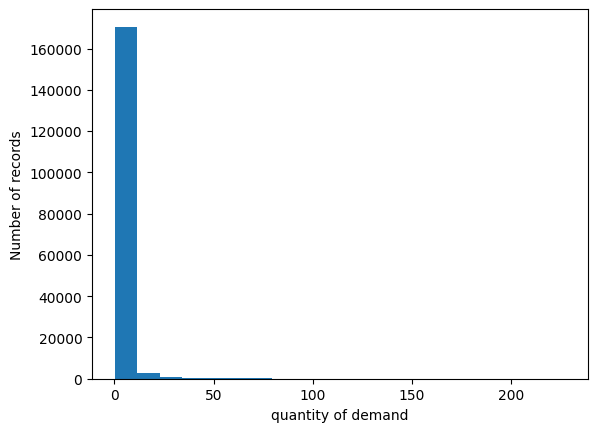

In [12]:
plt.hist(raw_filtered["demand"], bins=20)
plt.xlabel("quantity of demand")
plt.ylabel("Number of records")
plt.show()

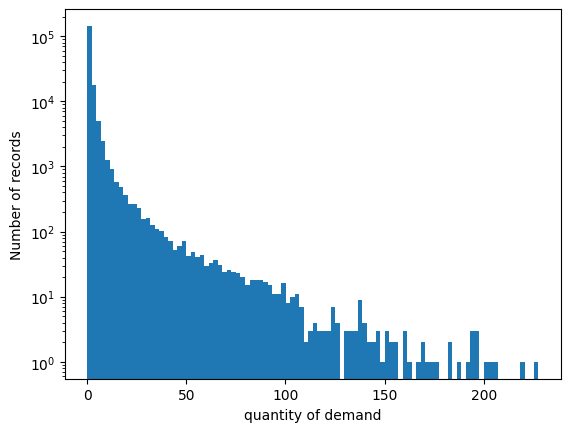

In [13]:
plt.hist(raw_filtered["demand"], bins=100)
plt.xlabel("quantity of demand")
plt.yscale("log")
plt.ylabel("Number of records")
plt.show()

# Playground v3


In [14]:
df_customers = raw_filtered.sort_values(by="demand", ascending=1)
n_customers = len(df_customers.index)

df_customers['demand_daily'] = df_customers['demand']
df_customers['demand_daily'] = df_customers['demand_daily'].astype("int64")
df_customers = df_customers[df_customers.demand_daily >0].sort_values(by="demand_daily",ascending=True).reset_index()

logger.info(f"N rows: {len(df_customers.index)}")

INFO:__main__:N rows: 71774


In [15]:
list_demand_daily = df_customers['demand_daily'].to_list()
logger.info(f"rows: {len(list_demand_daily)}")

INFO:__main__:rows: 71774


In [18]:
df_customers.groupby(['year','month']).agg(
    sum_demand_daily=('demand_daily','sum')
)

sum_demand_daily
year month                  
2020 1                  5524
     2                  5545
     3                  3651
     4                  3136
     5                  4368
     6                  5220
     7                  5766
     8                  4240
     9                  5722
     10                 7360
     11                 7693
     12                 9925
2021 1                  6619
     2                  1100
     3                  6535
     4                  6865
     5                  6367
     6                  5801
     7                  7352
     8                  7357
     9                  8430
     10                 9648
     11                 8676
     12                11985
2022 1                  7783
     2                 10302
     3                 10233
     4                  9306
     5                  9379
     6                 12658
     7                 11005
     8                 11064
     9                 12869
     10                14344
     11                13880
     12                17543

## A. Compute number of required layers

This approach consider the Kmeans algorithm to compute the ideal number of layer required, we used two metrics to determinate what is the best number of layers

In [ ]:
x = list_demand_daily

# set seed
SEED = 100

k_values = range(1, 11)

# score: elbow
inertia_values = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=SEED)
    
    kmeans.fit(np.array(x).reshape(-1, 1))
    inertia_values.append(kmeans.inertia_)

# Graficar la curva de la suma de las distancias cuadradas en función de K
plt.plot(k_values, inertia_values, 'bx-', label='Elbow')
plt.xlabel('Number of layers (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.legend()
plt.show()

In [ ]:
labels_by_k = []
for k_selected in [3]:
    logger.info(f"[Layers] Number of layers selected is {k_selected} \n")
    kmeans = KMeans(n_clusters=k_selected, random_state=SEED)
    kmeans.fit(np.array(x).reshape(-1, 1))

    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_

    for k in range(k_selected):
        cluster_data = np.array(x)[labels == k]
        #print(f"Cluster {k+1}: {cluster_data}")
        std_dev = np.std(cluster_data)
        mean_ = np.mean(cluster_data)
        logger.info("Layer {0}: Standart Desviation = {1} - Mean = {2}".format(k+1, std_dev, mean_))
        perc = len(cluster_data) * 100 / len(x)
        logger.info(f"Layer {k+1}: number of customers {len(cluster_data)} - {perc:.2f}% of total \n")
    logger.info(f"Total customers: {len(x)} \n\n\n")
    labels_by_k.append(labels)

In [ ]:
df_customers["layer_strategy_1"] = labels_by_k[0] # using 3 layers

## B. Generate Squared - Grid

In [ ]:
import os, sys
project_home = "/Users/pitehrhurtado/Documents/Operation-Researchs/clustering_discretization/src"
if project_home not in sys.path:
    sys.path = [project_home] + sys.path

In [ ]:
from app.discretization.grid import GridCreator

In [ ]:
grid_creator = GridCreator(df=df_customers,km_distance=1)

In [ ]:
df_output = grid_creator.run()
grid_df = grid_creator.geo.copy()

## C. Plot Grid

In [ ]:
from app.plot_grid.plot_grid import PlotGrid

In [ ]:
plotter = PlotGrid(
    grid_geo = grid_df,
    df = df_output,
)

In [ ]:
plotter.plot_density_customer()

In [ ]:
plotter.plot_grid_by_metric(metric="std")

## D. Plot Grid by LAYER

##### Consideration
color orange is used when pixel have number of customer least than 20

In [ ]:
def plot_by_layer(layer: int, df: pd.DataFrame, geo: gpd.GeoDataFrame, strategy: str) -> None:
    """
    """
    df_filtered = df[df[strategy] == layer].reset_index(drop=True)
    plotter = PlotGrid(
        grid_geo = geo,
        df = df_filtered,
    )
    logger.info(f"[PLOT-BY-LAYER] Layer {layer} is plotting")
    # n customer per pixel
    plotter.plot_density_customer()
    
    # std per pixel
    plotter.plot_grid_by_metric(metric="std")
    
    # mean per pixel
    plotter.plot_grid_by_metric(metric="mean")
    

# Considering 3-Layers

In [ ]:
# LAYER 0
plot_by_layer(
    layer=0,
    df=df_output,
    geo=grid_df,
    strategy = "layer_strategy_1"
)

In [ ]:
# LAYER 1
plot_by_layer(
    layer=1,
    df=df_output,
    geo=grid_df,
    strategy="layer_strategy_1"
)

In [ ]:
# LAYER 2
plot_by_layer(
    layer=2,
    df=df_output,
    geo=grid_df,
    strategy="layer_strategy_1"
)

In [ ]:
grid_df.rename(columns={"cell_id":"pixel_id"}, inplace=True)

In [ ]:
df_output.drop(['index'], axis=1, inplace=True)
df_output.rename(columns={"layer_strategy_1":"layer"}, inplace=True)

#### Saving data output

In [ ]:
grid_df.to_file("../data/geodf.geojson", driver='GeoJSON')

In [ ]:
df_output.to_csv("../data/output_layer_process.csv", index=False)